In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, scipy
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from spellchecker import SpellChecker 
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
df = pd.read_csv('C:/Users/Anurag/Downloads/sentiment_data_analytic_vidya.csv').drop('id', axis = 1)
df['tweet'] = df['tweet'].map(lambda x : x.lower())
df.head(3), df.shape

(   label                                              tweet
 0      0  #fingerprint #pregnancy test https://goo.gl/h1...
 1      0  finally a transparant silicon case ^^ thanks t...
 2      0  we love this! would you go? #talk #makememorie..., (7920, 2))

In [3]:
df1 = df.iloc[:4000].copy()

### Preprocessing:-

In [4]:
def punch(x):
    x = re.sub(r"[-()\"#/@;:@*<>{}`ð'+=~£|¦â.!%+-^$?,0-9]","", x)
    x = re.sub('$&@*#', 'vulgar', x) # Mention in data 
    x = re.sub(r"(\d+)(k)", r"\g<1>000", x) #expand 'k' to '000' eg. 50k to 50000
    x = re.sub("\\n", ' ', x)
    x = re.sub("\W", ' ', x)
    x = re.sub("\'s", " ", x) 
    x = re.sub("whats", "what is", x, flags=re.IGNORECASE)
    x = re.sub("\'ve", "have", x)
    x = re.sub("can't", "can not", x)
    x = re.sub("n't", "not", x)
    x = re.sub("i'm", "i am", x, flags = re.IGNORECASE)
    x = re.sub("\'re", "are", x)
    x = re.sub("\'d", "would", x)
    x = re.sub(r"http\S+", "", str(x))
    x = re.sub("e\.g\.", "eg", x, flags = re.IGNORECASE)
    x = re.sub("e-mail", "email", x, flags = re.IGNORECASE)
    x = re.sub(r"e - mail", "email", x)
    x = re.sub(r"US", "America", x)
    x = re.sub(r"USA", "America", x)
    x = re.sub(r"us", "America", x)
    x = re.sub(r"usa", "America", x)
    x = re.sub(r"Chinese", "China", x)
    x = re.sub(r"india", "India", x)
    x = re.sub("im", "i am", x, flags = re.IGNORECASE)
    x = re.sub("its", "it is", x, flags= re.IGNORECASE)
    x = re.sub("shes", "she is", x, flags = re.IGNORECASE)
    x = re.sub("u", "you", x, flags = re.IGNORECASE)
    x = re.sub("ur", "you are", x, flags = re.IGNORECASE)
    x = re.sub("wouldnt", "would not", x, flags = re.IGNORECASE)
    x = re.sub("youve",  "you have", x, flags = re.IGNORECASE)
    x = re.sub(r"\s{2,}", " ", x) # Remove extra space between words
    x = x.strip() # Remove extra space from begning and ending
    
    return(x)

df1['tweet'] = df1['tweet'].map(lambda x : punch(x))

### Feature Engineering:-

In [5]:
def remove_stopwords(x):
    return(' '.join([word for word in nltk.word_tokenize(x) if word not in stopwords.words('english')]))

def get_char_length_ratio(x): #To find how much word has meaningful content
    return len(x['tweet'])/max(1,len(x['tweet_without_stop_words']))

def get_Levenshtein(string1,string2): # Calculate Levenshtein distance to measure similiarity between string(edit base)
    import editdistance
    return editdistance.eval(string1,string2)

In [6]:
df1['tweet_without_stop_words'] = df1['tweet'].map(lambda x : remove_stopwords(x))
df1['char_length_ratio'] = df1.apply(lambda x : get_char_length_ratio(x), axis = 1)
df1['leve_distance'] = df1.apply(lambda x : get_Levenshtein(x['tweet'], x['tweet_without_stop_words']), axis = 1)

In [7]:
## Lexicon model based rating:-
from nltk.corpus import opinion_lexicon
pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())

sentiment = []
for x in df1['tweet_without_stop_words']:
    marks = 0
    for j in nltk.word_tokenize(x):
        if j in pos_list:
            marks += 1
        elif j in neg_list:
            marks -= 1
    sentiment.append(marks)
df1['lexicon_rating'] = sentiment

#### 1. Char langth ratio is imp, 1 contain high langth ratio distribution

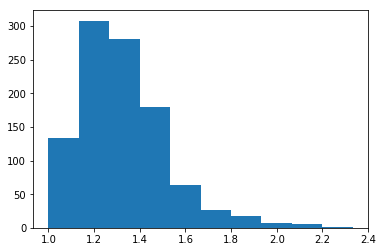

In [8]:
var = plt.hist(df1[df1['label'] == 1]['char_length_ratio'])

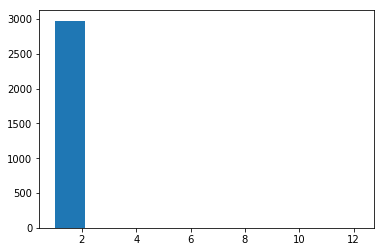

In [9]:
var = plt.hist(df1[df1['label'] == 0]['char_length_ratio'])

#### 2. Levenshte distance plot

In [ ]:
var = plt.hist(df1[df1['label'] == 1]['leve_distance'])

In [ ]:
var = plt.hist(df1[df1['label'] == 0]['leve_distance'])

In [10]:
df1.head(3)

,label,tweet,tweet_without_stop_words,char_length_ratio,leve_distance,lexicon_rating
0,0,fingerprint pregnancy test android apps beayou...,fingerprint pregnancy test android apps beayou...,1.000000,0,0
1,0,finally a transparant silicon case thanks to m...,finally transparant silicon case thanks youncl...,1.131579,10,1
2,0,we love this woyould yoyou go talk makememorie...,love woyould yoyou go talk makememories younpl...,1.091954,8,1


In [11]:
tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.99, strip_accents = 'unicode', ngram_range=(1, 1), min_df = 3) 
temp = tfidf.fit_transform(df1['tweet'])
temp

<4000x2184 sparse matrix of type '<class 'numpy.float64'>'
	with 33817 stored elements in Compressed Sparse Row format>

In [12]:
df1_new = pd.DataFrame(temp.toarray())
df1_new['char_length_ratio'] = df1['char_length_ratio']
df1_new['leve_distance'] = df1['leve_distance']
df1_new['lexicon_rating'] = df1['lexicon_rating']
df1_new['label'] = df1['label']

df1_new.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2178,2179,2180,2181,2182,2183,char_length_ratio,leve_distance,lexicon_rating,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.131579,10,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.091954,8,1,0


In [13]:
df1_new.shape

(4000, 2188)

In [14]:
x_dev, x_final, y_dev, y_final = train_test_split(df1_new.iloc[:,:-1], df1_new['label'], test_size = 0.1, random_state = 42)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_dev, y_dev, test_size = 0.2, random_state = 42)
x_train.shape, y_train.shape

((2880, 2187), (2880,))

In [36]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators = 500,
                       n_jobs=None, oob_score = True, random_state=42, verbose=0,
                       warm_start= True)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

In [38]:
model.fit(x_train, y_train)
pred = model.predict(x_test)

y_pred = []
for i in pred:
    if i <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

f1_score(y_test, np.array(y_pred).reshape(y_test.shape))
#0.7297

c:\users\anurag\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


0.7197802197802198

In [19]:
confusion_matrix(y_test, y_pred)

array([[494,  42],
       [ 59, 125]], dtype=int64)

In [ ]:
##############################################################

In [21]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=410,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.7178082191780822
[[494,  42],
       [ 59, 125]],

array([[481,  55],
       [ 53, 131]], dtype=int64)

In [ ]:
#######################################################

In [40]:
## MultiNaive Bayes:-
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=.4)

model.fit(x_train.iloc[:,:-1], y_train)
pred = model.predict(x_test.iloc[:,:-1])

y_pred = []
for i in pred:
    if i <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

f1_score(y_test, np.array(y_pred).reshape(y_test.shape))
#0.7297

0.7280701754385965

### Perameter Tuning:-

In [33]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV

# Choose the type of classifier. 
model = RandomForestClassifier(random_state = 42)

# Choose some parameter combinations to try
# learning_rate = [0.2, 0.22, 0.25] #  
criterion = ['entropy']
# splitter = ['best', 'random']
n_estimators = [350, 390, 410, 430, 450,471] # ,
max_depth = [43, 45, 47, 50, 53, 60] #, 
max_features = ['sqrt'] # 
# min_samples_leaf = [11,13,15,17]
# max_leaf_nodes = [5, 6, 7]
parameters = {'criterion' : criterion,  'n_estimators' : n_estimators,
             'max_depth': max_depth, 'max_features' : max_features }
               

# bootstrap=True, class_weight=None, criterion='entropy',
#                        max_depth=15, max_features='auto', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=200,
#                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
#                        warm_start=False

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(f1_score, greater_is_better=True)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator = model, param_distributions = parameters, scoring = acc_scorer, cv = 3)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
model = grid_obj.best_estimator_

# # Fit the best algorithm to the data. 
model.fit(x_train, y_train)
print(model)
# print()
pred = model.predict(x_test)
# # print(model.score(x_train, y_train))
# # print(model.score(x_test, y_test))
# # print(model.feature_importances_)
# # print(np.sqrt(metrics.mean_squared_error(y_test, pred)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=410,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [35]:
# model.fit(x_train, y_train)
# pred = model.predict(x_test)

y_pred = []
for i in pred:
    if i <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

f1_score(y_test, np.array(y_pred).reshape(y_test.shape))

0.7178082191780822

In [29]:
bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=410,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
    0.71780821

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=45, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
##########################################################################################################

### Test Data:-

In [3]:
df_test = pd.read_csv('test_sentiment-analytic.csv')
id_ = df_test['id']
df_test.drop('id', axis = 1, inplace = True)
df_test.shape

(1953, 1)

In [21]:
2187

2187

In [22]:
def punch(x):
    x = re.sub(r"[-()\"#/@;:@*<>{}`ð'+=~£|¦â.!%+-^$?,0-9]","", x)
    x = re.sub('$&@*#', 'vulgar', x) # Mention in data 
    x = re.sub(r"(\d+)(k)", r"\g<1>000", x) #expand 'k' to '000' eg. 50k to 50000
    x = re.sub("\\n", ' ', x)
    x = re.sub("\W", ' ', x)
    x = re.sub("\'s", " ", x) 
    x = re.sub("whats", "what is", x, flags=re.IGNORECASE)
    x = re.sub("\'ve", "have", x)
    x = re.sub("can't", "can not", x)
    x = re.sub("n't", "not", x)
    x = re.sub("i'm", "i am", x, flags = re.IGNORECASE)
    x = re.sub("\'re", "are", x)
    x = re.sub("\'d", "would", x)
    x = re.sub(r"http\S+", "", str(x))
    x = re.sub("e\.g\.", "eg", x, flags = re.IGNORECASE)
    x = re.sub("e-mail", "email", x, flags = re.IGNORECASE)
    x = re.sub(r"e - mail", "email", x)
    x = re.sub(r"US", "America", x)
    x = re.sub(r"USA", "America", x)
    x = re.sub(r"us", "America", x)
    x = re.sub(r"usa", "America", x)
    x = re.sub(r"Chinese", "China", x)
    x = re.sub(r"india", "India", x)
    x = re.sub("im", "i am", x, flags = re.IGNORECASE)
    x = re.sub("its", "it is", x, flags= re.IGNORECASE)
    x = re.sub("shes", "she is", x, flags = re.IGNORECASE)
    x = re.sub("u", "you", x, flags = re.IGNORECASE)
    x = re.sub("ur", "you are", x, flags = re.IGNORECASE)
    x = re.sub("wouldnt", "would not", x, flags = re.IGNORECASE)
    x = re.sub("youve",  "you have", x, flags = re.IGNORECASE)
    x = re.sub(r"\s{2,}", " ", x) # Remove extra space between words
    x = x.strip() # Remove extra space from begning and ending
    
    return(x)

def remove_stopwords(x):
    return(' '.join([word for word in nltk.word_tokenize(x) if word not in stopwords.words('english')]))

def get_char_length_ratio(x): #To find how much word has meaningful content
    return len(x['tweet'])/max(1,len(x['tweet_without_stop_words']))

def get_Levenshtein(string1,string2): # Calculate Levenshtein distance to measure similiarity between string(edit base)
    import editdistance
    return editdistance.eval(string1,string2)

############################################################
df_test['tweet'] = df_test['tweet'].map(lambda x : punch(x))
df_test['tweet_without_stop_words'] = df_test['tweet'].map(lambda x : remove_stopwords(x))
df_test['char_length_ratio'] = df_test.apply(lambda x : get_char_length_ratio(x), axis = 1)
df_test['leve_distance'] = df_test.apply(lambda x : get_Levenshtein(x['tweet'], x['tweet_without_stop_words']), axis = 1)

## Lexicon model based rating:-
from nltk.corpus import opinion_lexicon
pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())

sentiment = []
for x in df_test['tweet_without_stop_words']:
    marks = 0
    for j in nltk.word_tokenize(x):
        if j in pos_list:
            marks += 1
        elif j in neg_list:
            marks -= 1
    sentiment.append(marks)
df_test['lexicon_rating'] = sentiment
##############################################################

tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.99, strip_accents = 'unicode', ngram_range=(1, 1), min_df = 3) 
temp = tfidf.fit_transform(df_test['tweet'])

df1_new = pd.DataFrame(temp.toarray())
df1_new['char_length_ratio'] = df_test['char_length_ratio']
df1_new['leve_distance'] = df_test['leve_distance']
df1_new['lexicon_rating'] = df_test['lexicon_rating']
# df1_new['label'] = df_test['label']

# model.fit(x_train, y_train)


# f1_score(y_test, np.array(y_pred).reshape(y_test.shape))

In [21]:
df1_new.shape

(1953, 1314)

In [26]:
2186-1314

872

In [27]:
pred = model.predict(np.concatenate([np.concatenate([df1_new.iloc[:,:1315].values, np.zeros((1953, 869), dtype = np.float)],axis = 1), df1_new.iloc[:, -3:]], axis = 1))
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
y_pred = []
for i in pred:
    if i <= 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [28]:
result = pd.DataFrame({'id':id_})
result['label'] = y_pred
result.to_csv('result3_test_analytic.csv', index = False)

In [7]:
pd.read_csv('C:\\Users\Anurag\Downloads\\result4_test_analytic.csv')

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,1
4,7925,0
...,...,...
1948,9869,0
1949,9870,0
1950,9871,0
1951,9872,0


In [6]:
pd.read_csv('test_sentiment-analytic.csv')

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...
...,...,...
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old..."
1949,9870,Now Available - Hoodie. Check it out here - ht...
1950,9871,There goes a crack right across the screen. If...
1951,9872,@codeofinterest as i said #Adobe big time we m...
